In [183]:
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature
land_feature=cfeature.NaturalEarthFeature(category='physical',name='land',scale='10m',facecolor='grey')

In [44]:
ds = xr.open_dataset('datasets/global-reanalysis-phy-001-030-daily_med_2018.nc')
ds = ds.isel(depth=0).drop('depth')
ds

<xarray.Dataset>
Dimensions:    (latitude: 193, longitude: 565, time: 359)
Coordinates:
  * latitude   (latitude) float32 30.0 30.083334 30.166666 ... 45.916668 46.0
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-25T12:00:00
  * longitude  (longitude) float32 -5.0 -4.9166665 -4.8333335 ... 41.916668 42.0
Data variables:
    thetao     (time, latitude, longitude) float32 ...
    so         (time, latitude, longitude) float32 ...
Attributes:
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2019/04/04 11:59:50 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    comment:                            CMEMS product
    Conventions:                        CF-1.4
    domain_name:                        GL12
    FROM_ORIGINAL_FILE__field_type:     mean
    field_date:                         2018-12-25 00:00:00
    field_julian_date:                  25195.0
    julian_day_unit:                    days since 1950-01-01 00:00:00
    bulletin_date:                      2018-12-26 00:00:00
    bulletin_type:                      operational
    FROM_ORIGINAL_FILE__longitude_min:  -180.0
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    forecast_range:                     6-day_forecast
    forecast_type:                      hindcast
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [45]:
ds_stacked = ds.stack(N_TS=('latitude','longitude'))
ds_stacked

<xarray.Dataset>
Dimensions:    (N_TS: 109045, time: 359)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-25T12:00:00
  * N_TS       (N_TS) MultiIndex
  - latitude   (N_TS) float64 30.0 30.0 30.0 30.0 30.0 ... 46.0 46.0 46.0 46.0
  - longitude  (N_TS) float64 -5.0 -4.917 -4.833 -4.75 ... 41.83 41.92 42.0
Data variables:
    thetao     (time, N_TS) float32 nan nan nan nan nan ... nan nan nan nan nan
    so         (time, N_TS) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    title:                              daily mean fields from Global Ocean P...
    easting:                            longitude
    northing:                           latitude
    history:                            2019/04/04 11:59:50 MERCATOR OCEAN Ne...
    source:                             MERCATOR GLORYS12V1
    institution:                        MERCATOR OCEAN
    references:                         http://www.mercator-ocean.fr
    comment:                            CMEMS product
    Conventions:                        CF-1.4
    domain_name:                        GL12
    FROM_ORIGINAL_FILE__field_type:     mean
    field_date:                         2018-12-25 00:00:00
    field_julian_date:                  25195.0
    julian_day_unit:                    days since 1950-01-01 00:00:00
    bulletin_date:                      2018-12-26 00:00:00
    bulletin_type:                      operational
    FROM_ORIGINAL_FILE__longitude_min:  -180.0
    FROM_ORIGINAL_FILE__longitude_max:  179.91667
    FROM_ORIGINAL_FILE__latitude_min:   -80.0
    FROM_ORIGINAL_FILE__latitude_max:   90.0
    z_min:                              0.494025
    z_max:                              5727.917
    forecast_range:                     6-day_forecast
    forecast_type:                      hindcast
    _CoordSysBuilder:                   ucar.nc2.dataset.conv.CF1Convention

In [104]:
dl = ds_stacked['thetao'].where(~ds_stacked['thetao'].isnull(),drop=True).to_dataset()
dl

<xarray.Dataset>
Dimensions:    (N_TS: 45962, time: 359)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01T12:00:00 ... 2018-12-25T12:00:00
  * N_TS       (N_TS) MultiIndex
  - latitude   (N_TS) float64 30.33 30.33 30.33 30.33 ... 46.0 46.0 46.0 46.0
  - longitude  (N_TS) float64 18.92 19.0 19.08 19.17 ... 37.67 37.75 37.83 37.92
Data variables:
    thetao     (time, N_TS) float32 17.71279 17.85928 ... 4.8408146 4.822504

In [48]:
from tslearn.utils import to_time_series_dataset

/opt/anaconda3/envs/OceanPatterns/lib/python3.8/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [105]:
formatted_dataset = to_time_series_dataset(dl['thetao'].values.transpose())
print(formatted_dataset.shape)

(45962, 359, 1)


In [67]:
from tslearn.preprocessing import TimeSeriesScalerMinMax
scaled_dataset = TimeSeriesScalerMinMax(value_range=(0., 1.)).fit_transform(formatted_dataset)

In [120]:
# Euclidean k-means
n_clusters = 5
from tslearn.clustering import TimeSeriesKMeans
print("Euclidean k-means")
km = TimeSeriesKMeans(n_clusters=n_clusters, max_iter=50)
pred = km.fit_predict(scaled_dataset)

Euclidean k-means


In [125]:
dl['cluster'] = xr.DataArray(pred,dims=['N_TS'])

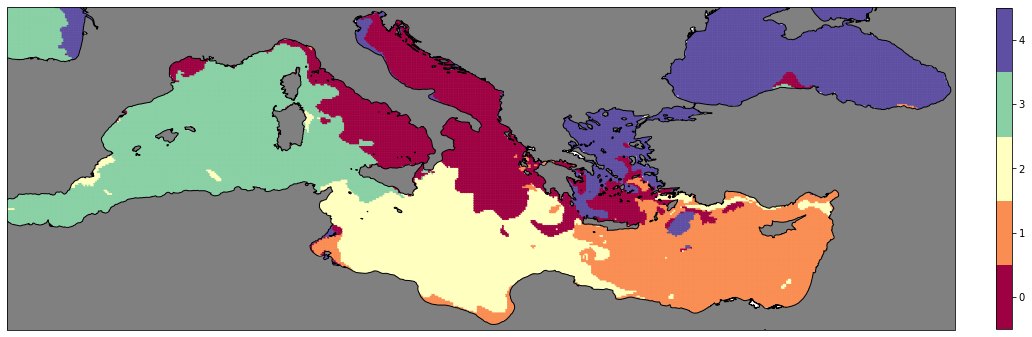

In [184]:
fig=plt.figure(figsize=(18,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.add_feature(land_feature, edgecolor='black')
ax.set_extent([-5, 42, 30, 46], crs=ccrs.PlateCarree())
plt.scatter(dl['longitude'].values,dl['latitude'].values,s=2,c=pred,vmin=0,vmax=n_clusters-1,cmap=plt.cm.get_cmap('Spectral', n_clusters))
plt.colorbar(ticks=range(n_clusters),fraction=0.016, pad=0.04)
plt.clim([-0.5,4.5])
plt.show()


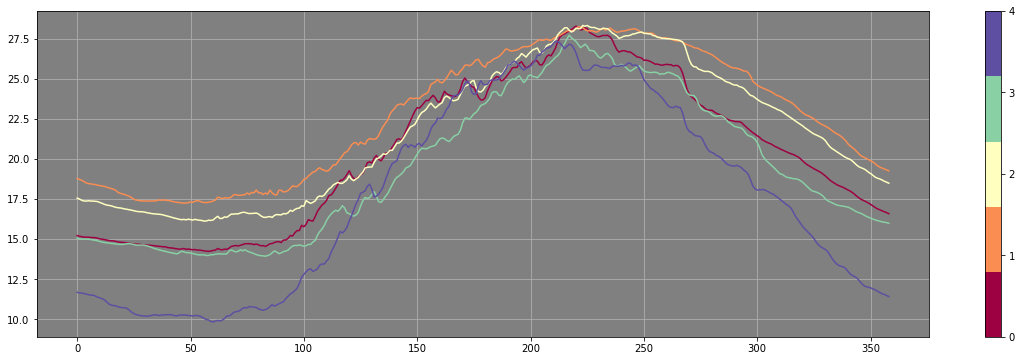

In [182]:
cmap=plt.cm.get_cmap('Spectral', n_clusters)
plt.figure(figsize=(20,6))
plt.gca().set_facecolor('grey')
plt.grid()
for yi in range(n_clusters):
    plt.plot(dl['thetao'].where(dl['cluster']==yi,drop=True).mean('N_TS'),color=cmap(yi))

norm = mpl.colors.Normalize(vmin=0,vmax=n_clusters-1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(n_clusters))    
plt.show()    